In [4]:
import sys
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

sys.path.append(os.path.abspath('..'))
from preprocessing import shroom_dealer

## Comparative barcharts

In order to get a glimpse of what specific attribute values could be used to determine if a mushroom was edible or poisonous we generated some barcharts to compare the attribute values by poisonous and edible mushrooms.

The following function can be used to collect the frequencies of each attribute value for two attributes.

In [36]:
def attr_freqs(attr1, attr2):
    df = shroom_dealer.get_data_frame()

    labels1 = shroom_dealer.get_attribute_dictionary()[attr1]
    labels2 = shroom_dealer.get_attribute_dictionary()[attr2]

    data = []

    for a in df[attr1].cat.categories:
        column = df[attr2][df[attr1] == a].value_counts()
        data.append(column)

    observed = pd.concat(data, axis=1)
    observed.columns = [labels1[a] for a in df[attr1].cat.categories]

    return observed


attr_freqs('odor', 'poisonous')

,almond,creosote,foul,anise,musty,none,pungent,spicy,fishy
e,400,0,0,400,0,3408,0,0,0
p,0,192,2160,0,36,120,256,576,576


Next we can use this function to plot the comparative data.

In [37]:
def plot_comparative_data(attr, plot=True, save=False):
    data = attr_freqs(attr, 'poisonous')

    labels = shroom_dealer.get_attribute_dictionary()[attr]

    index = np.arange(o.shape[1])
    bar_width = 0.35
    opacity=0.4

    fig, ax = plt.subplots()

    plt.bar(index, data.loc['e',:].values, bar_width, align='center',
            color='b', label='edible', alpha=opacity)
    plt.bar(index + bar_width, data.loc['p',:].values, bar_width,
            align='center', color='r', label='poisonous', alpha=opacity)

    plt.xlabel('Attributes')
    plt.ylabel('Frequency')
    plt.title('Frequency by attribute and edibility ({})'.format(attr))
    plt.xticks(index + bar_width / 2, data.columns)

    plt.legend()

    plt.tight_layout()
    plt.show()
    plt.close()

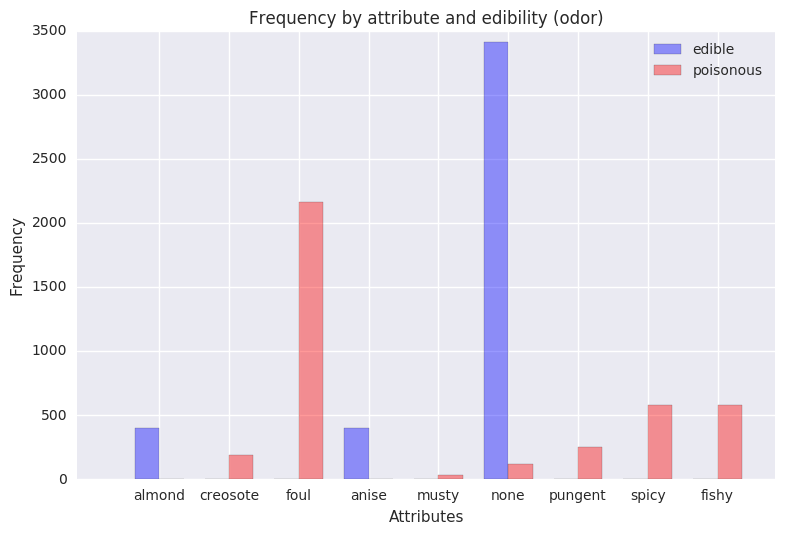

In [38]:
plot_comparative_data('odor')

From the plot we can see that any mushroom with a foul, spicy and fishy smell as almost certainly poisonous. No smell is almost always edible, but in some rare cases it can be posionous.

Let's take a look at spore print color.

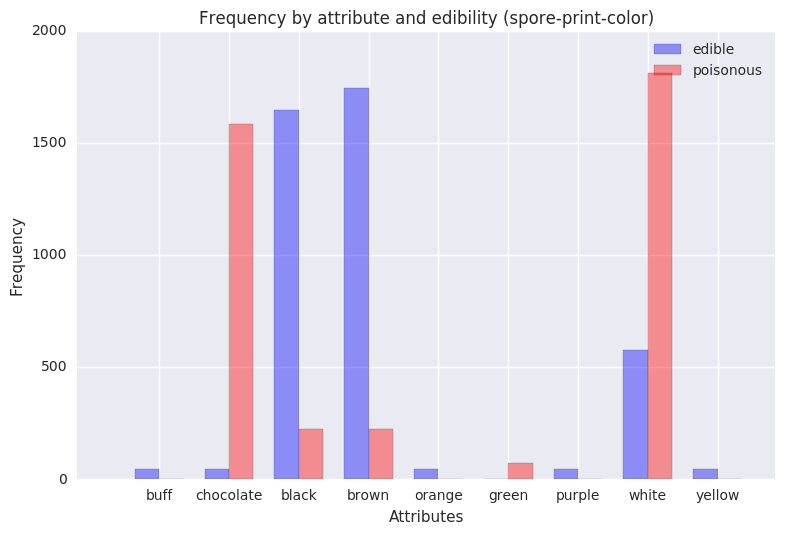

In [39]:
plot_comparative_data('spore-print-color')

We can see that chocolate and white mushrooms are usually poisonous so it is best to avoid those. Black or brown are usually edible, but not always.

## Determining an attribute's association with edibility

To determine association between attributes and edibility we used Pearson's chi-squared test on the frequency of attribute values and then ordered the attributes in descending order of the chi-squared statistic. The chi-squared test works by comparing the observed data to expected data (the null hypothesis which is an even distribution across each row and column) with the following equation,

$$
    \chi^2 = \sum^n_{i=1} \frac{ (O_i - E_i)^2 }{ E_i }
$$

where O is the observed data point and E is the expected data point.




With the following functions we can get a contingency table of the expected and observed values of any two attributes:

In [40]:
def expected_data(observed):
    expected = np.zeros(observed.shape)

    total = observed.sum().sum()
    for j in [0, 1]:
        for i, col_total in enumerate(observed.sum()):
            row_total = observed.sum(axis=1)[j]
            expected[j][i] = row_total*col_total/total

    return pd.DataFrame(expected, index=observed.index,
                        columns=observed.columns)

In [41]:
o = attr_freqs('odor', 'poisonous')
o

,almond,creosote,foul,anise,musty,none,pungent,spicy,fishy
e,400,0,0,400,0,3408,0,0,0
p,0,192,2160,0,36,120,256,576,576


In [42]:
expected_data(o)

,almond,creosote,foul,anise,musty,none,pungent,spicy,fishy
e,207.188577,99.450517,1118.818316,207.188577,18.646972,1827.40325,132.600689,298.351551,298.351551
p,192.811423,92.549483,1041.181684,192.811423,17.353028,1700.59675,123.399311,277.648449,277.648449


Using these two tables for each attribute we can collect the chi-squared test statistic for each, and then sort them in descending order to rank the attributes by association with being poisonous or edible.

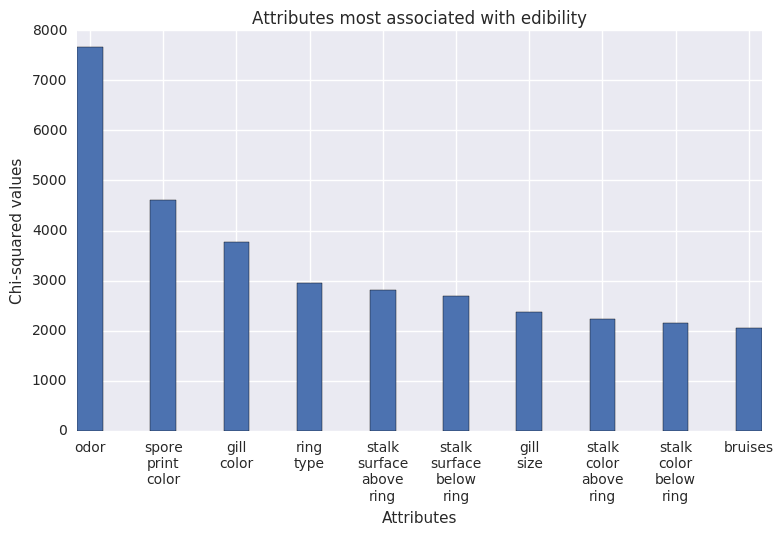

In [43]:
cat_names = shroom_dealer.get_attribute_dictionary().keys()

chisqrs = []
for cat in cat_names:
    if cat != 'poisonous':
        observed = observed_data(cat, 'poisonous')
        expected = expected_data(observed)
        chisqr = (((observed-expected)**2)/expected).sum().sum()
        chisqrs.append((chisqr, cat))

chisqrs = sorted(chisqrs)[::-1]
chisqrs = chisqrs[:10]
values = [d[0] for d in chisqrs]
labels = [d[1].replace("-", "\n") for d in chisqrs]

index = np.arange(len(chisqrs))
bar_width = .35
opacity=0.4

plt.title("Attributes most associated with edibility")
plt.bar(index, values, bar_width, align='center')
plt.xticks(index, labels)
plt.ylabel("Chi-squared values")
plt.xlabel("Attributes")
plt.autoscale()
plt.tight_layout()
plt.show()

As we can see from the plot, odor is the most associated attribute with edibility, followed by spore print color and gill color. These rankings seem to agree heavily with our comparative barcharts.

While this use of the chi-squared test statistic may not be the traditional use of finding the p-value and accepting or rejecting the null hypothesis to determine independence, it still provided us with a metric to rank the attributes by their association of edibility.